In [1]:
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name:
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

def create_data(data_filename):
    conn=create_connection("original_data.db", delete_db=True)
    create_table_sql='''
    CREATE TABLE IF NOT EXISTS Original (
    ID INTEGER PRIMARY KEY,
    Age INTEGER,
    Experience INTEGER,
    Income INTEGER,
    ZIPCode INTEGER,
    Family INTEGER,
    CCAvg REAL,
    Education INTEGER,
    Mortgage INTEGER,
    PersonalLoan INTEGER,
    SecuritiesAccount INTEGER,
    CDAccount INTEGER,
    Online INTEGER,
    CreditCard INTEGER
    )'''

    create_table(conn,create_table_sql)
    cur=conn.cursor()
    with open(data_filename) as file:
        header=next(file)
        for line in file:
            rows=line.strip().split(',')
            cur.executemany("insert into Original( ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?)",(rows, ))
    conn.commit()
    conn.close()

In [2]:
create_data("Bank_Personal_Loan_Modelling.csv")

In [3]:
def insert_Customer(conn, values):
    sql = '''INSERT INTO Customer (ID, Age, Experience, Income, ZIP_Code, Family, CCAvg, Education, Mortgage) 
             VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid
def insert_product(conn, values):
    sql = '''INSERT INTO Product (ID,Personal_Loan, Securities_Account, CD_Account, Online, CreditCard) 
             VALUES (?, ?, ?, ?,?,?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid
conn = create_connection("original_data.db")
conn_normalized = create_connection("normalized_data.db", delete_db=True)
create_table_sql = '''
CREATE TABLE IF NOT EXISTS Customer (
    ID INT PRIMARY KEY,
    Age INT,
    Experience INT,
    Income FLOAT,
    ZIP_Code INTEGER,
    Family INT,
    CCAvg FLOAT,
    Education INT,
    Mortgage FLOAT
);
'''
create_table(conn_normalized, create_table_sql)
create_table_sql = '''
CREATE TABLE IF NOT EXISTS Product (
                ID INTEGER,
                Personal_Loan INTEGER,
                Securities_Account INTEGER,
                CD_Account INTEGER,
                Online INTEGER,
                CreditCard INTEGER,
                FOREIGN KEY (ID) REFERENCES Customer(ID)
            );
'''
create_table(conn_normalized, create_table_sql)
sql_statement = '''SELECT * FROM Original'''
r = execute_sql_statement(sql_statement, conn)

with conn_normalized:
    for row in r:
        ID=row[0]
        insert_Customer(conn_normalized, (row[0:9], ))
        product_data = (row[0],) + row[9:]
        insert_product(conn_normalized, (product_data,))

conn_normalized.commit()
conn_normalized.close()

In [4]:
import sqlite3
import pandas as pd
conn_normalized = sqlite3.connect("normalized_data.db")
sql_statement = '''
    SELECT c.ID, c.Age, c.Experience, c.Income, c.ZIP_Code, c.Family, c.CCAvg, c.Education, c.Mortgage,
           p.Personal_Loan, p.Securities_Account, p.CD_Account, p.Online, p.CreditCard
    FROM Customer c
    JOIN Product p ON c.ID = p.ID;
'''
data = pd.read_sql_query(sql_statement, conn_normalized)
conn_normalized.close()

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, stratify=data['Personal_Loan'], random_state=503)

In [7]:
data=train

In [8]:
data.head()

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
2823,2824,33,7,21.0,90095,1,0.6,3,0.0,0,1,0,0,0
4912,4913,51,26,28.0,94061,1,1.3,2,94.0,0,1,0,1,0
45,46,57,31,52.0,94720,4,2.5,1,0.0,0,0,0,0,1
78,79,54,30,133.0,93305,2,2.6,3,0.0,1,0,0,0,0
2224,2225,38,12,29.0,92084,2,1.4,3,0.0,0,0,0,1,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 2823 to 2543
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  3500 non-null   int64  
 1   Age                 3500 non-null   int64  
 2   Experience          3500 non-null   int64  
 3   Income              3500 non-null   float64
 4   ZIP_Code            3500 non-null   int64  
 5   Family              3500 non-null   int64  
 6   CCAvg               3500 non-null   float64
 7   Education           3500 non-null   int64  
 8   Mortgage            3500 non-null   float64
 9   Personal_Loan       3500 non-null   int64  
 10  Securities_Account  3500 non-null   int64  
 11  CD_Account          3500 non-null   int64  
 12  Online              3500 non-null   int64  
 13  CreditCard          3500 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 410.2 KB


In [10]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(data, title="Profiling Report")
# profile

In [11]:
numerical_cols = ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage','Education']
data[numerical_cols] = data[numerical_cols].astype(float)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 2823 to 2543
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  3500 non-null   int64  
 1   Age                 3500 non-null   float64
 2   Experience          3500 non-null   float64
 3   Income              3500 non-null   float64
 4   ZIP_Code            3500 non-null   int64  
 5   Family              3500 non-null   float64
 6   CCAvg               3500 non-null   float64
 7   Education           3500 non-null   float64
 8   Mortgage            3500 non-null   float64
 9   Personal_Loan       3500 non-null   int64  
 10  Securities_Account  3500 non-null   int64  
 11  CD_Account          3500 non-null   int64  
 12  Online              3500 non-null   int64  
 13  CreditCard          3500 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 410.2 KB


In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,3500.0,2489.086571,1446.091354,1.0,1242.75,2473.5,3750.5,5000.0
Age,3500.0,45.354000,11.494651,23.0,35.00,45.0,55.0,67.0
Experience,3500.0,20.119143,11.492599,-3.0,10.00,20.0,30.0,43.0
Income,3500.0,73.852857,46.037117,8.0,39.00,63.0,100.0,218.0
ZIP_Code,3500.0,93148.146000,1760.357455,90005.0,91910.00,93407.0,94608.0,96651.0
Family,3500.0,2.384857,1.152628,1.0,1.00,2.0,3.0,4.0
CCAvg,3500.0,1.941934,1.746359,0.0,0.70,1.5,2.6,10.0
Education,3500.0,1.886000,0.838062,1.0,1.00,2.0,3.0,3.0
Mortgage,3500.0,56.792000,101.082318,0.0,0.00,0.0,102.0,590.0
Personal_Loan,3500.0,0.096000,0.294633,0.0,0.00,0.0,0.0,1.0


In [14]:
from scipy import stats
data_except_loan = data.drop(columns=['Personal_Loan'])
z_scores = stats.zscore(data_except_loan)
abs_z_scores = np.abs(z_scores)
outlier_indices = (abs_z_scores > 3).any(axis=1)
data_cleaned = data[~outlier_indices]
num_outliers_removed = sum(outlier_indices)
print("Number of outliers removed:", num_outliers_removed)

Number of outliers removed: 338


In [15]:
data=data_cleaned
data.shape

(3162, 14)

In [16]:
data.describe()

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
count,3162.000000,3162.000000,3162.000000,3162.00000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.0,3162.000000,3162.000000
mean,2496.959203,45.334598,20.088868,68.33871,93141.383934,2.395636,1.713438,1.909235,47.223593,0.064832,0.086022,0.0,0.573055,0.263125
std,1447.379683,11.512781,11.507724,41.61447,1763.753148,1.161992,1.401025,0.836707,82.512674,0.246269,0.280440,0.0,0.494712,0.440399
min,1.000000,23.000000,-3.000000,8.00000,90005.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1253.250000,35.000000,10.000000,38.00000,91910.000000,1.000000,0.600000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2483.500000,45.000000,20.000000,61.00000,93311.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
75%,3752.750000,55.000000,30.000000,89.00000,94608.000000,4.000000,2.400000,3.000000,93.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,5000.000000,67.000000,43.000000,205.00000,96651.000000,4.000000,7.000000,3.000000,359.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [17]:
data_cleaned = data[data['Experience'] >= 0]
num_removed_rows = len(data) - len(data_cleaned)
print("Number of rows with negative Experience removed:", num_removed_rows)

Number of rows with negative Experience removed: 36


In [18]:
data=data_cleaned

In [19]:
data.describe()

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
count,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.0,3126.000000,3126.000000
mean,2499.633077,45.571657,20.336532,68.378439,93138.674664,2.389635,1.712879,1.904671,47.125400,0.065579,0.086372,0.0,0.573576,0.262636
std,1446.883408,11.362358,11.338402,41.711517,1766.196395,1.162538,1.404678,0.836295,82.280031,0.247584,0.280958,0.0,0.494636,0.440137
min,1.000000,24.000000,0.000000,8.000000,90005.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1259.250000,36.000000,11.000000,38.000000,91910.000000,1.000000,0.600000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2483.500000,46.000000,20.000000,61.000000,93311.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
75%,3754.750000,55.000000,30.000000,89.750000,94608.000000,3.000000,2.400000,3.000000,94.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,5000.000000,67.000000,43.000000,205.000000,96651.000000,4.000000,7.000000,3.000000,359.000000,1.000000,1.000000,0.0,1.000000,1.000000


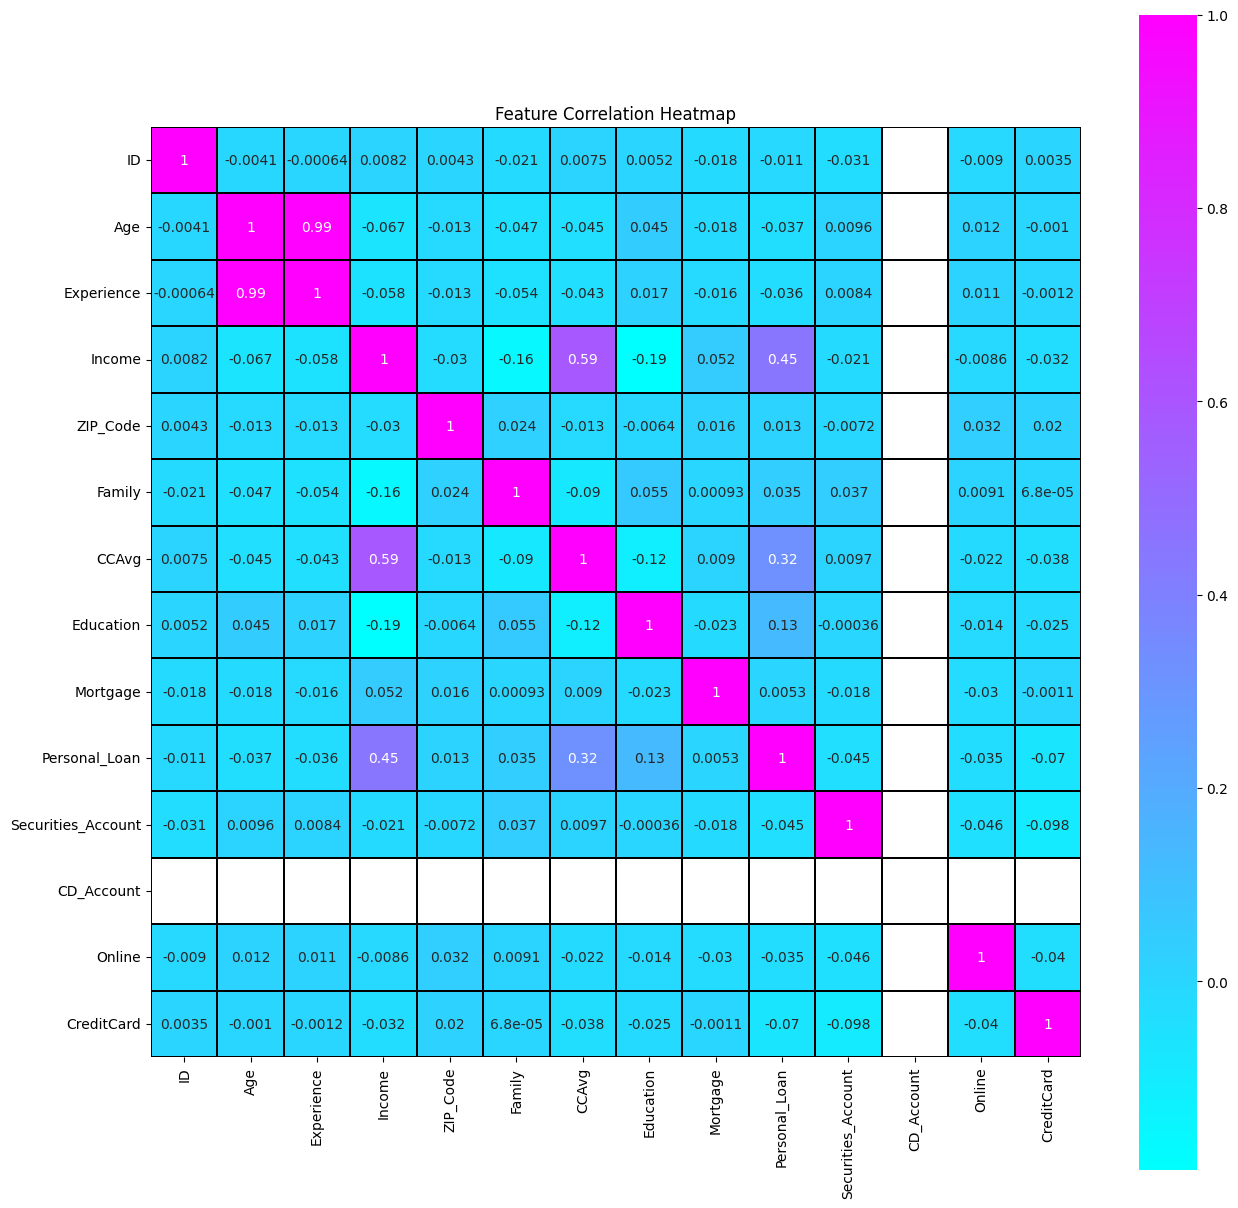

In [20]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),square=True,annot=data.corr(),cmap='cool',linecolor='black',linewidth=0.003)
plt.title('Feature Correlation Heatmap')
plt.show()

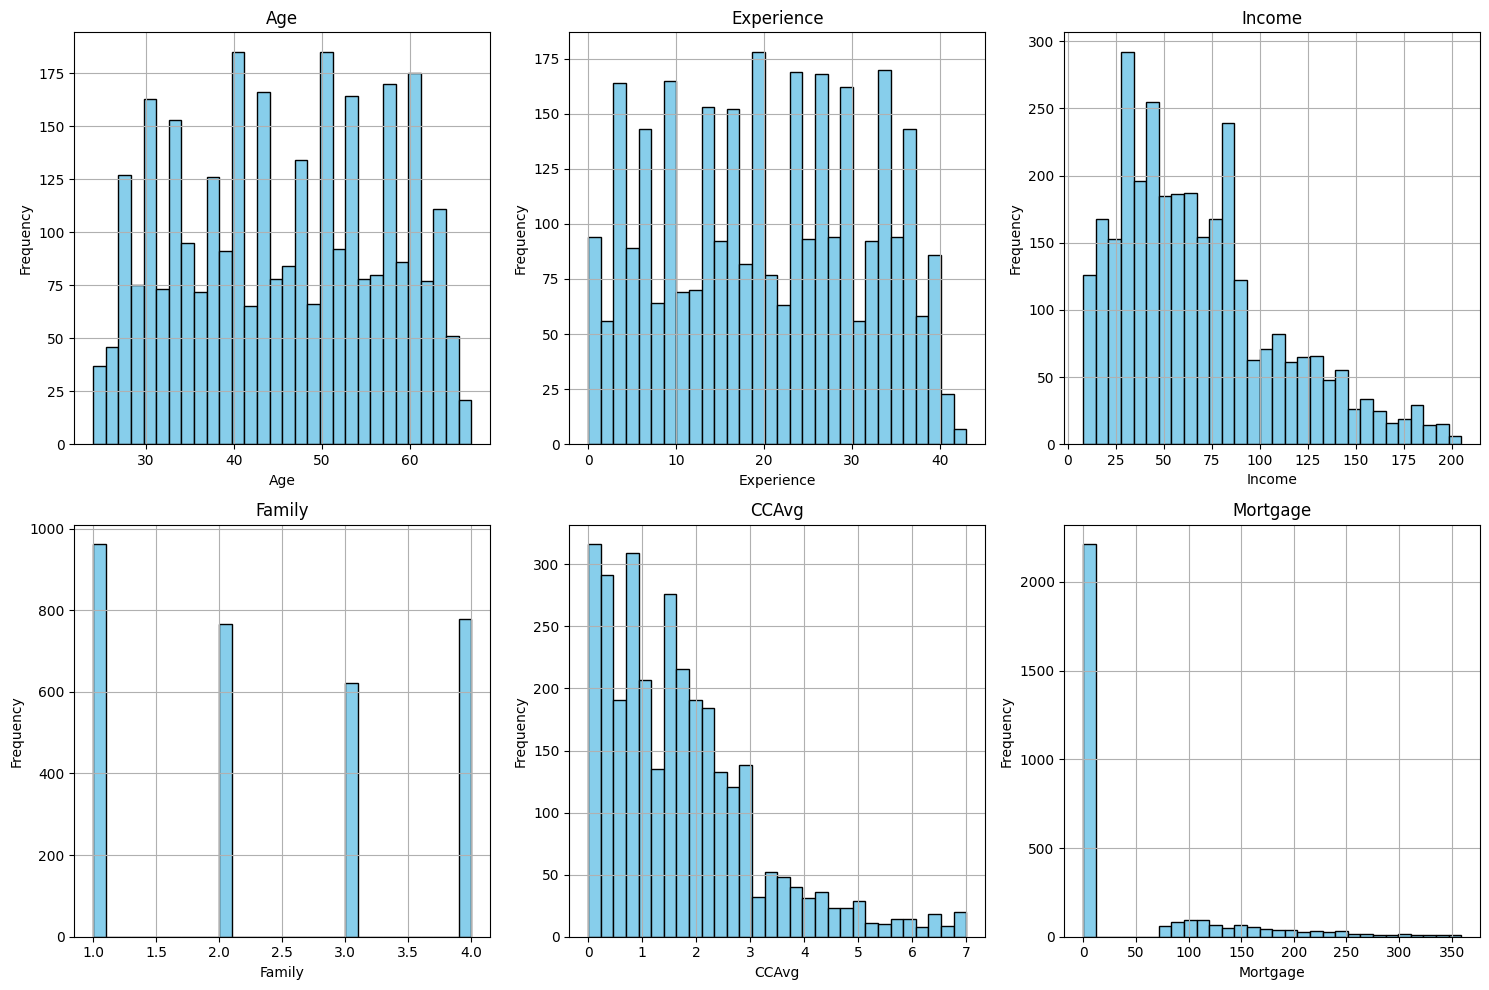

In [21]:
numerical_cols = ['Age','Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    data[col].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


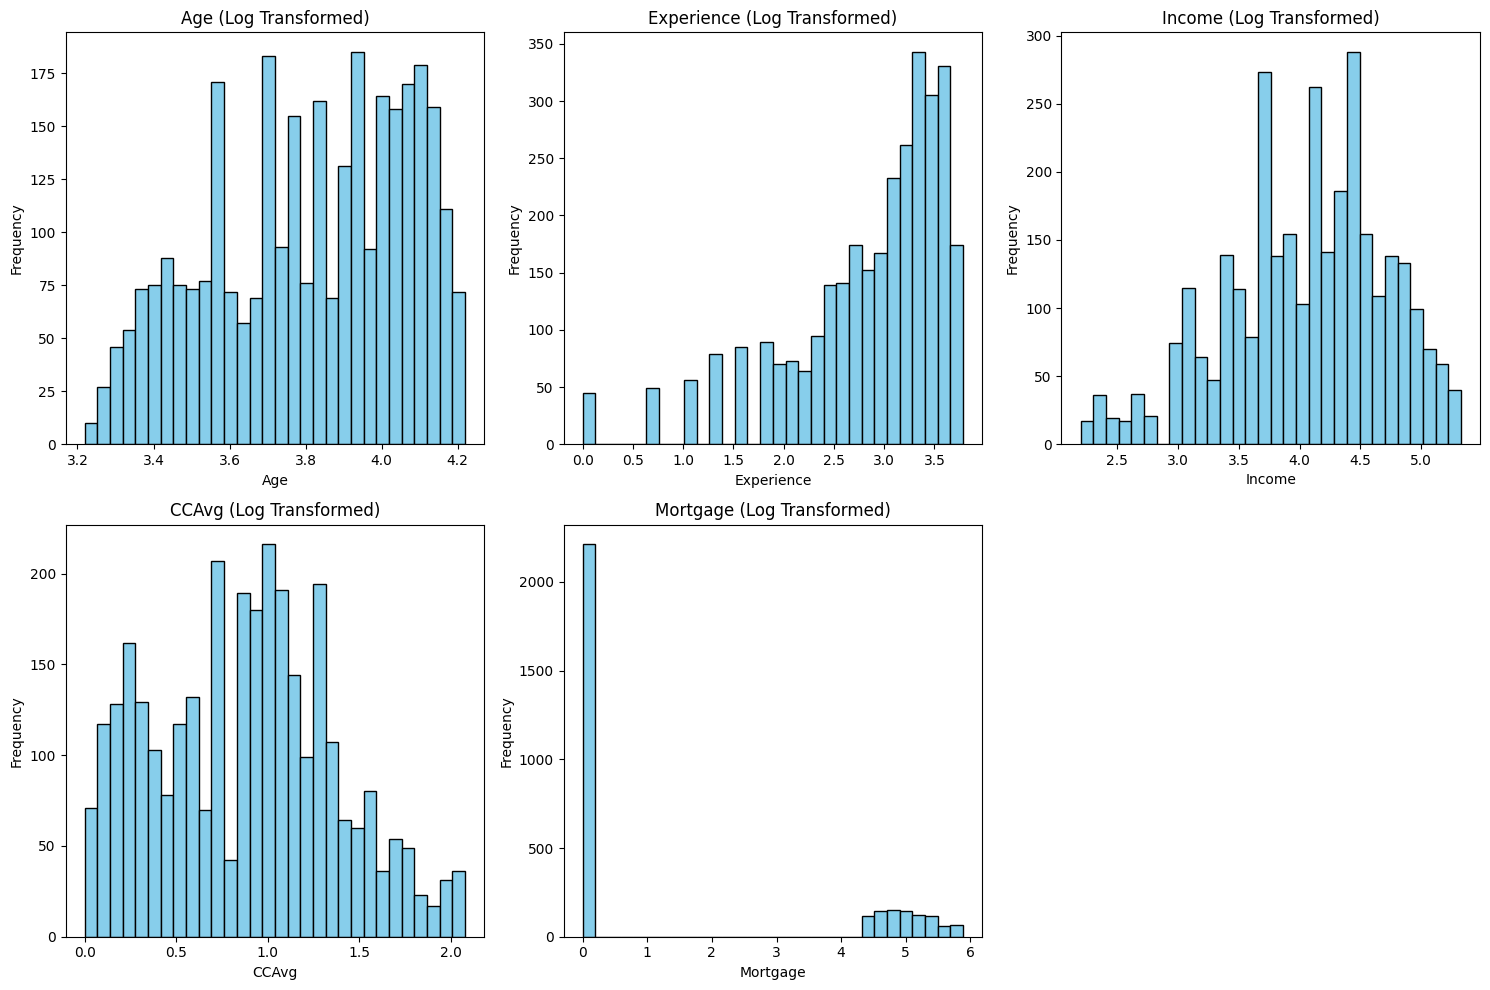

In [22]:
numerical_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    transformed_data = np.log1p(data[col]) 
    plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black')
    plt.title(col + ' (Log Transformed)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin): 
    numerical_columns = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
    categorical_columns = ['Securities_Account', 'Online', 'CreditCard']
    
    def fit(self, X, y=None): 

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])
        
        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 
        
        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])
        
        return self 

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equivalent
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [24]:
preprocessor = Preprocessor()
preprocessor.fit(data)
train_fixed = preprocessor.transform(data)

In [25]:
train_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3126 entries, 2823 to 2543
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    3126 non-null   int64  
 1   Age                   3126 non-null   float64
 2   Experience            3126 non-null   float64
 3   Income                3126 non-null   float64
 4   ZIP_Code              3126 non-null   int64  
 5   Family                3126 non-null   float64
 6   CCAvg                 3126 non-null   float64
 7   Education             3126 non-null   float64
 8   Mortgage              3126 non-null   float64
 9   Personal_Loan         3126 non-null   int64  
 10  CD_Account            3126 non-null   int64  
 11  Securities_Account_0  3126 non-null   int32  
 12  Securities_Account_1  3126 non-null   int32  
 13  Online_0              3126 non-null   int32  
 14  Online_1              3126 non-null   int32  
 15  CreditCard_0          3

In [26]:
train_fixed

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,CD_Account,Securities_Account_0,Securities_Account_1,Online_0,Online_1,CreditCard_0,CreditCard_1
2823,2824,-1.106607,-1.176415,-1.136042,90095,1.0,-0.792393,3.0,-0.572836,0,0,0,1,1,0,1,0
4912,4913,0.477824,0.499574,-0.968195,94061,1.0,-0.293979,2.0,0.569787,0,0,0,1,0,1,1,0
45,46,1.005968,0.940624,-0.392723,94720,4.0,0.560446,1.0,-0.572836,0,0,1,0,1,0,0,1
78,79,0.741896,0.852414,1.549498,93305,2.0,0.631649,3.0,-0.572836,1,0,1,0,1,0,1,0
2224,2225,-0.666487,-0.735365,-0.944217,92084,2.0,-0.222776,3.0,-0.572836,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,2322,-0.402415,-0.470735,-0.704437,91380,3.0,-0.863595,3.0,-0.572836,0,0,1,0,1,0,1,0
4237,4238,1.270040,1.205254,0.230706,90401,3.0,1.913286,1.0,-0.572836,0,0,0,1,1,0,1,0
1384,1385,0.829920,0.940624,-0.152942,91711,1.0,0.062032,3.0,-0.572836,0,0,1,0,0,1,1,0
2097,2098,-0.754511,-0.823575,-1.303888,90740,3.0,-1.148403,2.0,0.800743,0,0,1,0,0,1,1,0


In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
rfr = make_pipeline(Preprocessor(), LogisticRegression(max_iter=1000))

In [28]:
rfr

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [29]:
y_train = data['Personal_Loan']
X_train = data.drop('Personal_Loan', axis=1)
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [30]:
Accuracy_train=rfr.score(X_train,y_train)
y_train_hat=rfr.predict(X_train)

In [31]:
y_test = test['Personal_Loan']
X_test = test.drop('Personal_Loan', axis=1)

In [32]:
params = rfr.get_params()
params 

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('logisticregression', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'logisticregression': LogisticRegression(max_iter=1000),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 1000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [33]:
#mlflow models build-docker -m runs:/5c6e4814175243b9b1ef257745512dff/loan_acceptance -n loan_acceptancev1 --enable-mlserver

In [34]:
Accuracy_test=rfr.score(X_test,y_test)

In [35]:
import mlflow
from mlflow.models import infer_signature
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Project")

with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    mlflow.log_metric("Acurracy_train", Accuracy_train)
    #mlflow.log_metric("mean_absolute_error", mae)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "RandomForestRegressor model for housing data, n_estimators=50")

    # Infer the model signature
    signature = infer_signature(X_train, rfr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfr,
        artifact_path="loan_acceptance",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="rfr_moodel_transformed",
    )

C:\Users\rupes\anaconda3\install\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\rupes\anaconda3\install\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'rfr_moodel_transforme

In [36]:
mlflow models serve -m runs:/5c6e4814175243b9b1ef257745512dff/loan_acceptance -p 5000

SyntaxError: invalid decimal literal (2087180287.py, line 1)

In [ ]:
import json
import requests

payload = json.dumps({'inputs': {
  "Age": 25,
  "Experience": 2,
  "Income": 113,
  "ZIP Code": 91108,
  "Family": 4,
  "CCAvg": 1.8,
  "Educaton": 2,
  "Mortage": 150,
   
   
}})
response = requests.post(
    url=f"http://localhost:5000/invocations",
    data=payload,
    headers={"Content-Type": "application/json"},
)
print(response.json())